# Multi-Armed Bandit Line Jump

In this notebook, we test our knowledge of multi-armed bandits on the a line wark problem. The formulation of a line walk problem is as follows:
- We have a line scaled from 0 to $\texttt{max\_scale}$.
- We set sample random two variables $\texttt{agent\_position}$ and $\texttt{goal}$ in the line scale. These are:
    - $\texttt{agent\_position}$: our agent position
    - $\texttt{goal}$: our goal position
- We can perfom a jump from a set of n jumps which basically determines how the agent towards to the goal.
- Objective: Find the jump to makes the agent reach the goal (or at least be the closest possible).

### Import

In [315]:
import time
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(int(time.time()))

## Environment

We start by creating the environment which is a fairly simple one.
- We generate the goal and the agent position
- Our reward at a given time step is given by:

$$ P_t = \frac{1}{|\texttt{agent\_positon}_t - \texttt{goal}| + 1}$$

$$

R_t = X \sim \mathrm{Bern}(P_t)
$$

In [316]:
class LineWalkEnvironment:
    def __init__(self, max_scale) -> None:
        self.max_scale = max_scale
        self.goal = np.random.randint(0, self.max_scale)
        self.agent_position = self.get_new_agent_position(self.max_scale, self.goal)
        
    def get_new_agent_position(self, max_scale, goal):
        # sample the position of the agent while 
        # excluding the goal position
        tmp = list(range(max_scale))
        tmp.remove(goal)
        return np.random.choice(tmp)
        
    def jump(self, step):
        """We jump according to a bernoulli distribution"""
        agent_position = self.agent_position + step
        reward =  1 / (np.abs(self.goal - agent_position) + 1)
        
        if np.random.random() < reward:
            return 1
        else:
            return 0

## Agent

- The only information our greedy agent has is:
    - The set of actions it can perform.
    - The expected gain of each action along over time.
- We update our expected reward for each action according to the following formula.

$$
Q_t(a)=\frac{R_1+R_2+\cdots+R_{N_t(a)}}{N_t(a)}
$$

- To compute the running recursively, we use the following formula.

$$
Q_t(a)= Q_{t - 1}(a)+ \frac{1}{N_t(a)} (R_{N_t(a)} - Q_{t - 1}(a))
$$

In [317]:
class Jumper:
    def __init__(self, allowed_jumps, epsilon = 0) -> None:
        assert 0 <= epsilon <= 1.0
        self.epsilon = epsilon
        self.allowed_jumps = allowed_jumps
        assert isinstance(allowed_jumps, list) and len(allowed_jumps) > 1
        self.expected_reward = [np.random.random() for _ in range(len(self.allowed_jumps))]
        self.actions_counts = [0] * len(allowed_jumps)
        
    def jump(self, environment):
        if np.random.random() > self.epsilon:
            step_idx = np.argmax(self.expected_reward)
        else:
            step_idx = np.random.randint(len(self.allowed_jumps))
            
        reward = environment.jump(self.allowed_jumps[step_idx])
        
        # update the cumulative reward of our agent
        # by recursively computing the average
        self.actions_counts[step_idx] += 1  
        self.expected_reward[step_idx] = self.expected_reward[step_idx] + (1.0 / self.actions_counts[step_idx]) * (reward - self.expected_reward[step_idx])
        return self.expected_reward[step_idx]
        
    def reset(self):
        self.expected_reward = [np.random.random() for _ in range(len(self.allowed_jumps))]

## Training

Let us train our agent to find the best direction to walk through the path towards the goal.

In [332]:
scale = 500
timesteps = 1000

env = LineWalkEnvironment(scale)

# create available 10 jumps such that 
# there exists only few possible jumps 
actions = np.random.randint(-scale, scale, 5)

print(f"agent position: {env.agent_position}")
print(f"goal position: {env.goal}")
print(f"best jump: {actions[np.argmin([np.abs((env.agent_position + position) - env.goal) for position in actions])]}") 

agent position: 312
goal position: 451
best jump: 76


### Greed Solution  (select best action)

We will use the approach to select the action at that time step

Text(510.4494949494949, 0.5, 'Expected Reward')

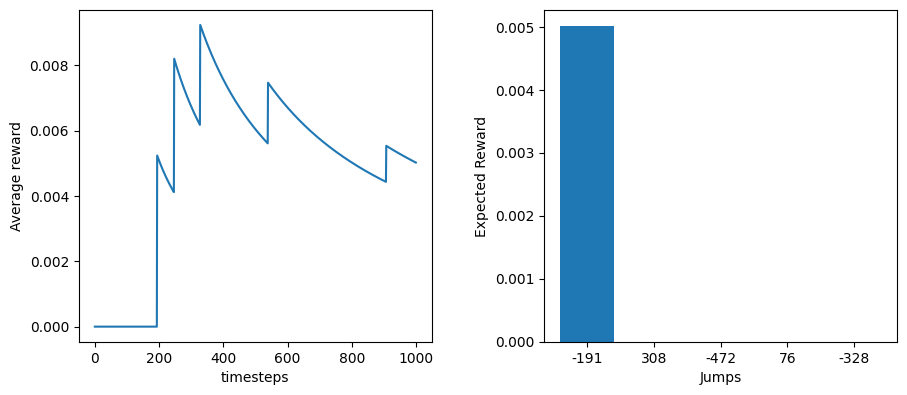

In [333]:
greedy_agent = Jumper(list(actions), epsilon=0.0)

reward = []

for _ in range(timesteps):
    reward.append(greedy_agent.jump(env))
    
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

plt.tight_layout(pad=5.0)

ax[0].plot(range(len(reward)), reward)
ax[0].set_xlabel('timesteps')
ax[0].set_ylabel('Average reward')

ax[1].bar([str(jump) for jump in greedy_agent.allowed_jumps], greedy_agent.expected_reward)
ax[1].set_xlabel('Jumps')
ax[1].set_ylabel('Expected Reward')

In [334]:
print(f"Regret: {timesteps - sum(reward)}")

Regret: 995.0952882080038


### $\epsilon$-Greed Solution  (select best action)

We will use the approach to select the action at that time step

Text(510.4494949494949, 0.5, 'Expected Reward ($\\epsilon = 0.1$)')

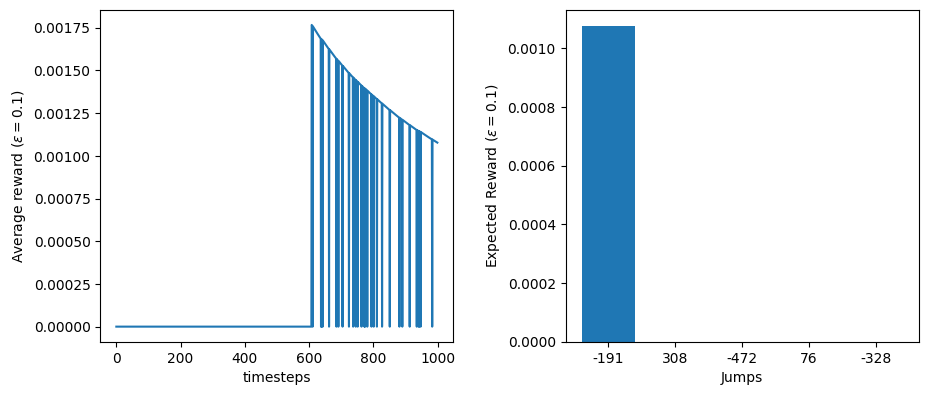

In [335]:
epsilon = 0.1
e_greedy_agent = Jumper(list(actions), epsilon=epsilon)

reward = []

for _ in range(timesteps):
    reward.append(e_greedy_agent.jump(env))
    
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

plt.tight_layout(pad=5.0)

ax[0].plot(range(len(reward)), reward)
ax[0].set_xlabel('timesteps')
ax[0].set_ylabel(f'Average reward ($\epsilon = {epsilon}$)')

ax[1].bar([str(jump) for jump in e_greedy_agent.allowed_jumps], e_greedy_agent.expected_reward)
ax[1].set_xlabel('Jumps')
ax[1].set_ylabel(f'Expected Reward ($\epsilon = {epsilon}$)')

In [336]:
print(f"Regret: {timesteps - sum(reward)}")

Regret: 999.5041399967262


TODO:
- Run experiment over average